In [1]:
import gymnasium as gym
import my_package
import torch
import numpy as np
import matplotlib.pyplot as plt

from my_package.core.AC_v4 import AC_agent

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/paolo/.local/lib/python3.6/site-packages/gymnasium/core.py:27: UserWarning: WARN: Gymnasium minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gymnasium minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


In [2]:
data = torch.load('ShipRovCont-v0_750_ep_final.pth')

state_dim = data['state_dim']
action_dim = data['action_dim']
max_episodes = data['max_episodes']

buffer_params = data['buffer_params']
noise_type = data['noise_type']
noise_params = data['noise_params']
AC_params = data['AC_params']
trained_env_options = data['trained_env_options']
env_options = data['env_options']
env_name = data['env_name']
workspace = data['workspace']

""" Init AC agent """
agent = AC_agent(
    state_size=state_dim,
    action_size=action_dim,
    max_episodes=max_episodes,
    device=device,
    noise_params=noise_params,
    noise_type=noise_type,
    AC_params=AC_params,
    buffer_params=buffer_params
)

agent.actor.load_state_dict(data['actor_state_dict'])

<All keys matched successfully>

In [3]:
env = gym.make(env_name, Options=trained_env_options, render_mode='human', workspace=workspace)
for ep in range(2):
    state, info = env.reset()
    done = False
    
    total_reward = 0
    while not done:
        action = agent.act(state, add_noise=False)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
        total_reward += reward
        
    if info['collision']:
        ending_cause = "collision"
    elif info['out_of_bounds']:
        ending_cause = "out of bounds"
    elif info['time_limit']:
        ending_cause = "max steps reached"
    elif info['coverage'] == 100:
        ending_cause = "100% coverage"
    else:
        ending_cause = "unkown"
    print('total reward: ' + str(total_reward) + ' end episode for: ' + ending_cause)

env.close()

/home/paolo/miniconda3/envs/zenoenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
  return f(*args, **kwds)


total reward: 142.7800000000001 end episode for: 100% coverage
total reward: 142.74999999999994 end episode for: 100% coverage


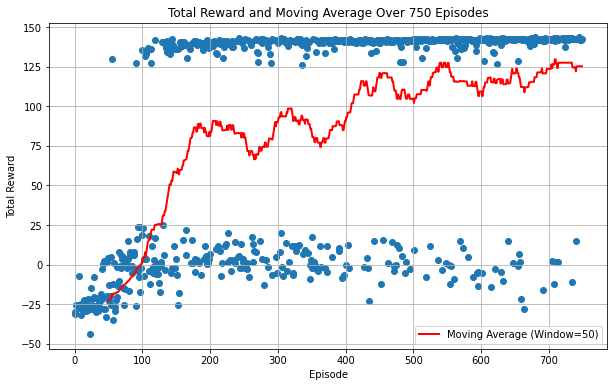

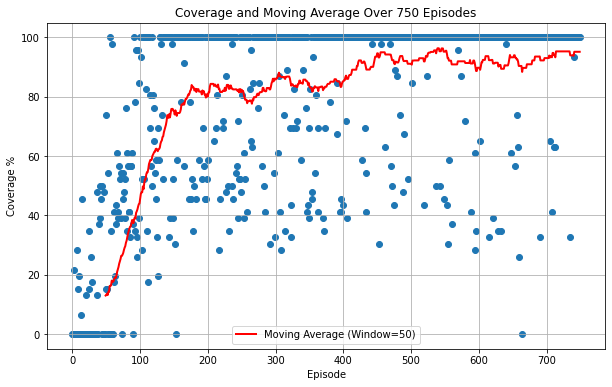

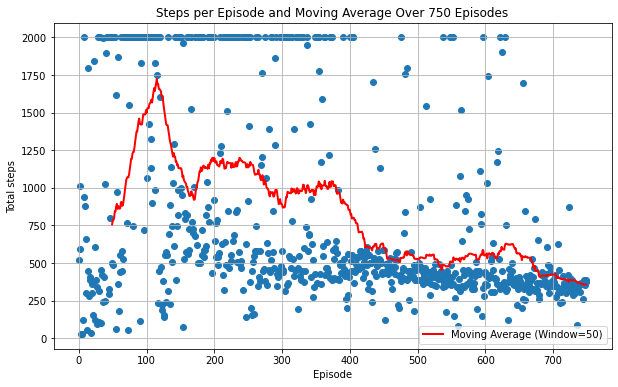

In [6]:
total_rewards = data['total_rewards']
coverage_per_ep = data['coverage_per_ep']
len_episodes = data['len_episodes']

""" Plot rewards """
window_size = 50
ma_reward = np.convolve(total_rewards, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(total_rewards)), total_rewards)
plt.plot(np.arange(window_size - 1, len(total_rewards)), ma_reward, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title(f'Total Reward and Moving Average Over {max_episodes} Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

""" Plot coverage """
ma_coverage = np.convolve(coverage_per_ep, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(coverage_per_ep)), coverage_per_ep)
plt.plot(np.arange(window_size - 1, len(coverage_per_ep)), ma_coverage, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title(f'Coverage and Moving Average Over {max_episodes} Episodes')
plt.xlabel('Episode')
plt.ylabel('Coverage %')
plt.legend()
plt.grid(True)
# plt.savefig('coverage.jpeg')

plt.show()
""" Plot episode duration """
ma_steps = np.convolve(len_episodes, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(len_episodes)), len_episodes)
plt.plot(np.arange(window_size - 1, len(len_episodes)), ma_steps, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title(f'Steps per Episode and Moving Average Over {max_episodes} Episodes')
plt.xlabel('Episode')
plt.ylabel('Total steps')
plt.legend()
plt.grid(True)
plt.show()

""" Plot alpha decay """
if 'alpha_decay' in data.keys():
    lr_per_ep = data['lr_per_ep']
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(lr_per_ep)), lr_per_ep, label='LR Decay')
    plt.title('LR Decay per Episode')
    plt.xlabel('Episode')
    plt.ylabel('LR')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# Options['ship_perimeter'] = 8
import imageio 

images = []
Options['draw_lidar'] = True

env = gym.make(env_name, Options=Options, render_mode='rgb_array')
state, info = env.reset()
img = env.render()
done = False
total_reward = 0
while not done:
    images.append(img)
    action = select_action(state, policy_net, 0, action_dim)
    next_state, reward, terminated, truncated, info = env.step(action)
    img = env.render()
    done = terminated or truncated
    state = next_state
    total_reward += reward
images.append(img)
print('total reward: ' + str(total_reward))
env.close()
# if total_reward > 8:
# imageio.mimsave("ShipQuest_failed.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=20)
# imageio.imsave("Agent.jpeg", img)